# Meta genomics DWV logboek
## Is er een nieuwe DWV primer nodig?

## Data
De data voor dit onderzoek is verkregen op 5 november 2019, en er is een eerder kort onderzoek op 5 and 18 december 2019 naar deze data gedaan. Uit het eerdere onderzoek is gebleken dat de genoomsequentie van DWV 11kb lang is. De data gemaakt tijdens het vorige onderzoek wordt in dit logboek vergeleken met onze eigen data.

## Benodigdheden
Alle door ons gebruikte libraries en dependencies staan in het bijgevoegde environments.yaml, Hier kan een conda environment van gemaakt worden met het volgende commando:
> $ conda env create --name [envname] --file=environments.yml
>
Deze conda environment kan worden geactiveerd met het volgende commando:
> $ conda activate [envname]
>
Vervang in deze commando's '[envname]' met een omgevingsnaam naar keuze. \
Alle libraries/dependencies hebben wij met behulp van pip install of conda install in onze conda environment geïnstalleerd.

Door ons gebruikte tools/programma's:
- Awk (5.2.1) 
- Clustal Omega (1.2.4) 
- Guppy (6.5.7+ca6d6af) 
- Vsearch (v2.22.1_linux_x86_64)


Naast guppy, die op het graphix1 systeem (Intel® i5-8600K, dual NVIDIA GeForce GTX 1080 Ti, 64GB MEM) is gerunt, zijn alle tools op het assemblix systeem (Intel® Xeon® Gold 6248 Processor, Integrated Matrox G200eW3, 881GB MEM) gerunt.

## Basecalling
Basecalling is het vertalen van de elektrische stroomveranderingen die waren gemeten toen de nucleotiden door de Nanopore gingen, naar nucleobasen (een A,T,C of G). Voor deze vertaling zijn er meerdere tools om uit te kiezen. De snelste en best presterende basecaller is <a href="https://github.com/nanoporetech/dorado">Dorado</a>, dus we begonnen met deze. \
Na alles te installeren en het te runnen kregen we deze error: 

> No supported chemistry for Flowcell:'FLO-MIN106', Kit:'SQK-RNA001' and Sampling Rate:3012 

Onze data is met een FLO-MIN106 Flowcell gebasecalled.
Volgens een github comment van raronan op de dorado pagina: https://github.com/nanoporetech/dorado/issues/214 Is onze pore versie r9.4.1. 

Het lijkt erop dat dorado ons type flowcell niet ondersteunt. Als we opzoeken of dorado specifiek deze flowcell ondersteunt kunnen we niet direct wat over ons type vinden. Maar wel een kort lijstje aan versies die niet meer ondersteund worden, deze lijst https://github.com/nanoporetech/dorado/issues/650 gaat van r9.5 tot r10.4, onze versie (r0.4.1) is ouder dan dit. Het lijkt erop dat wij niet dorado kunnen gebruiken voor onze data. 

We hebben besloten de basecalling met <a href="https://timkahlke.github.io/LongRead_tutorials/BS_G.html">Guppy</a> te doen, deze tool werkt met oude(re) flowcells. Guppy is echter wel minder snel dan Dorado.

### Guppy

<a href="https://timkahlke.github.io/LongRead_tutorials/BS_G.html">Guppy</a> is een basecaller die sinds eind 2017 openbaar beschikbaar is. \
Wij hebben guppy gebruikt om de fast5 data opnieuw te basecallen. Hiervoor hebben wij deze rule gebruikt:


In [ ]:
rule guppy: 

input: 

'/commons/Themas/Thema07/metagenomics/DWV/Sick_Beezzz/20191218_1217_MN30556_FAL66274_dd5dacb8/fast5_pass/' 

output: 

'/students/2023-2024/Thema07/Sick_beez/guppy_out/' 

shell: 

'/opt/ont/ont-guppy/bin/guppy_basecaller -i {input} -s {output} -c /opt/ont/ont-guppy/data/rna_r9.4.1_70bps_hac.cfg --min_qscore 7 --recursive -x 'cuda:0' --num_callers 4 --gpu_runners_per_device 4 --chunks_per_runner 1024 --chunk_size 1000 --compress_fastq' 

 

Guppy is op elk bestand toegepast met een minimale Q-score van 7, met 4 paralelle basecallers, elk 
verwerkt 1024 chunks van 1000 base lang. De output is gecomprimeerd in het FastQ-formaat. 

Wij hebben het nieuwere model 6.5.7+ca6d6af gebruikt zodat <a href="https://timkahlke.github.io/LongRead_tutorials/BS_G.html">Guppy</a> accurater de bases uit de fast5 files kan callen. Wij hebben dit op het graphix1 systeem gerunt op een NVIDIA GeForce GTX 1080 Ti. Het basecallen van alle data duurde ongeveer 15 minuten. \
Basecallen werd vroeger op uitsluitend CPU (processor) gedaan, maar tegenwoordig wordt er meestal een CUDA enabled GPU gebruikt. Op deze pagina van Nvidia staan alle CUDA Enabled GPU's: https://developer.nvidia.com/cuda-gpus. CUDA is eigendom van Nvidia, en dus de enige producent.

In de home stonden de conda channels, hier stond een URL bij, deze hebben wij verwijderd zodat we weer met guppy kunnen basecallen.  

## Quality control
Quality control helpt bij het snel identificeren van reads van slechte kwaliteit, het vinden/aantonen van problemen met de gegevens en geeft algemene informatie over de gegeven sample.
Voor de quality control twijfelden we tussen de tools: <a href="https://github.com/s-andrews/FastQC">FastQC</a> en <a href="https://github.com/wdecoster/NanoPlot">NanoPlot</a>. We hadden meer ervaring met fastqc, maar NanoPlot is specifiek voor MinION/Nanopore data gemaakt, wat onze data is. Na met beide kort een testrun te doen zijn we op NanoPlot uitgekomen. NanoPlot is makkelijker in gebruik voor MinION/Nanopore data.

### NanoPlot op de oude data
De door ons gebruikte Nanopore data is al eerder gebasecalled in december 2016 met guppy versie 3.2.6+afc8e14. Om te beginnen gingen we de kwaliteit van deze oude data kijken.

In [ ]:
rule nanoplot:
    input: 
        reads="/homes/haroorda/periode_7/sick_beez/zipje/your_archive.tar.gz" 
    output: 
        html="results_2/nanoplot_reads.html", 
    shell: 
        """ 
        mkdir -p temp_directory && \ 
        tar -zxvf {input.reads} -C temp_directory && \ 
        NanoPlot --fastq temp_directory/*.fastq -o {output.html} && \ 
        rm -rf temp_directory 
        """ 

We hebben <a href="https://github.com/wdecoster/NanoPlot">NanoPlot</a> geprobeerd te runnen op de oude data. Bij het proberen om NanoPlot op onze folder met guppy data te runnen onstonden veel errors, die niet makkelijk op te lossen waren. Volgens de documentatie had dit moeten kunnen op de fastq files. We gaan later kijken of we van al onze losse fastq bestanden, één kunnen maken. En dan op dat bestand Nanoplot te runnen. Daarvoor moeten we een manier vinden om NanoPlot op 1 bestand toe passen. 

In [ ]:
/commons/docent/Thema07/metagenomics/DWV/Sick_Beezzz/20191218_1217_MN30556_FAL66274_dd5dacb8/guppy_out_fast/pass$ NanoPlot --fastq fastq_runid_61214d90674fb476eeea0df13759443ace338524_0_0.fastq -o ~/Desktop/test_nanoplot 

We liepen op deze manier niet tegen errors aan. De gemiddelde quality van dit ene bestand is 8.5.

### NanoPlot op de nieuwe data
We hebben <a href="https://github.com/wdecoster/NanoPlot">NanoPlot</a> op de nieuwe versie van hetzelfde bestand toegepast. NanoPlot op een hele map te toepassen werkt vooralsnog niet. We hebben de NanoPlots van de oude en nieuwe gebasecallede data vergeleken en we zagen dat de gemiddelde quality van 8.5 naar 9.9 ging.

Op alle data die uit onze guppy run kwam hebben wij NanoPlot gerunt. Omdat dit niet op de hele folder kan, hebben we het per bestand gedaan. Hiervoor hebben wij deze code gebruikt:

In [ ]:
input_folder="/students/2023-2024/Thema07/Sick_beez/guppy_out/pass/" 

counter=0 

for file in "$input_folder"*.fastq.gz; do 

counter_str=$(printf "%04d" $counter) 

NanoPlot --fastq "$file" --outdir /students/2023-2024/Thema07/Sick_beez/Nanoplot/ --prefix "$counter_str" --only-report 

((counter++)) 

done 

We gebruiken hierbij de ‘--only-report’ command line option, dit zorgt ervoor dat er alleen een rapport wordt gegenereerd, en geen interactieve plots.


Omdat we het per bestand runnen, eindigen we met 60 losse NanoPlot html-bestanden. We moeten eerst de fastq files die uit guppy komen samenvoegen tot 1 groot fastq bestand. Wat we al wel konden zien in de 60 gemaakte NanoPlot bestanden was dat er reads waren die tussen de 10 en 11 duizend baseparen zaten. Dit komt overeen met de lengte van het DWV genoom dat in het vorige onderzoek was aangetoond. Als wij een bestand maken waar alle reads in staan kunnen wij daarna alle reads boven de 10k baseparen selecteren om alleen de DWV genomen op te nemen.

### Cat command
Hieronder worden de files geconcataneerd met behulp van het <a href="https://www.ibm.com/docs/en/aix/7.2?topic=c-cat-command">cat commando</a>. Het is niet heel efficient, maar het werkt wel. FASTQ en FASTA bestanden bestaan alleen uit tekst, de stukken tekst van meerdere bestanden kunnen zonder problemen in 1 bestand achter elkaar worden geplaatst. \
Als input pakken we alle bestanden uit '/students/2023-2024/Thema07/Sick_beez/guppy_out/pass/' die eindigen op '.fastq.gz', deze bestanden unzippen we met <a href="https://www.geeksforgeeks.org/gunzip-command-in-linux-with-examples/">gunzip</a>, dat voegen we dan aan elkaar met het cat commando. Tot slot zippen we het bestand met <a href="https://www.gzip.org/">gzip</a>. De output is 1 grote (.fastq.fz) file met alle fastq files erin verwerkt. 

In [ ]:
cat /students/2023-2024/Thema07/Sick_beez/guppy_out/pass/*.fastq.gz | gunzip -c > /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq 

gzip /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq

Nu runnen we NanoPlot op het geconcateneerde fastq bestand. In plaats van voor elke van de 60 input files een output file maken, blijft er op deze manier één html bestand over.

In [ ]:
NanoPlot --fastq "/students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz" --outdir /students/2023-2024/Thema07/Sick_beez/big_nanoplot/ --prefix "big_" --only-report 

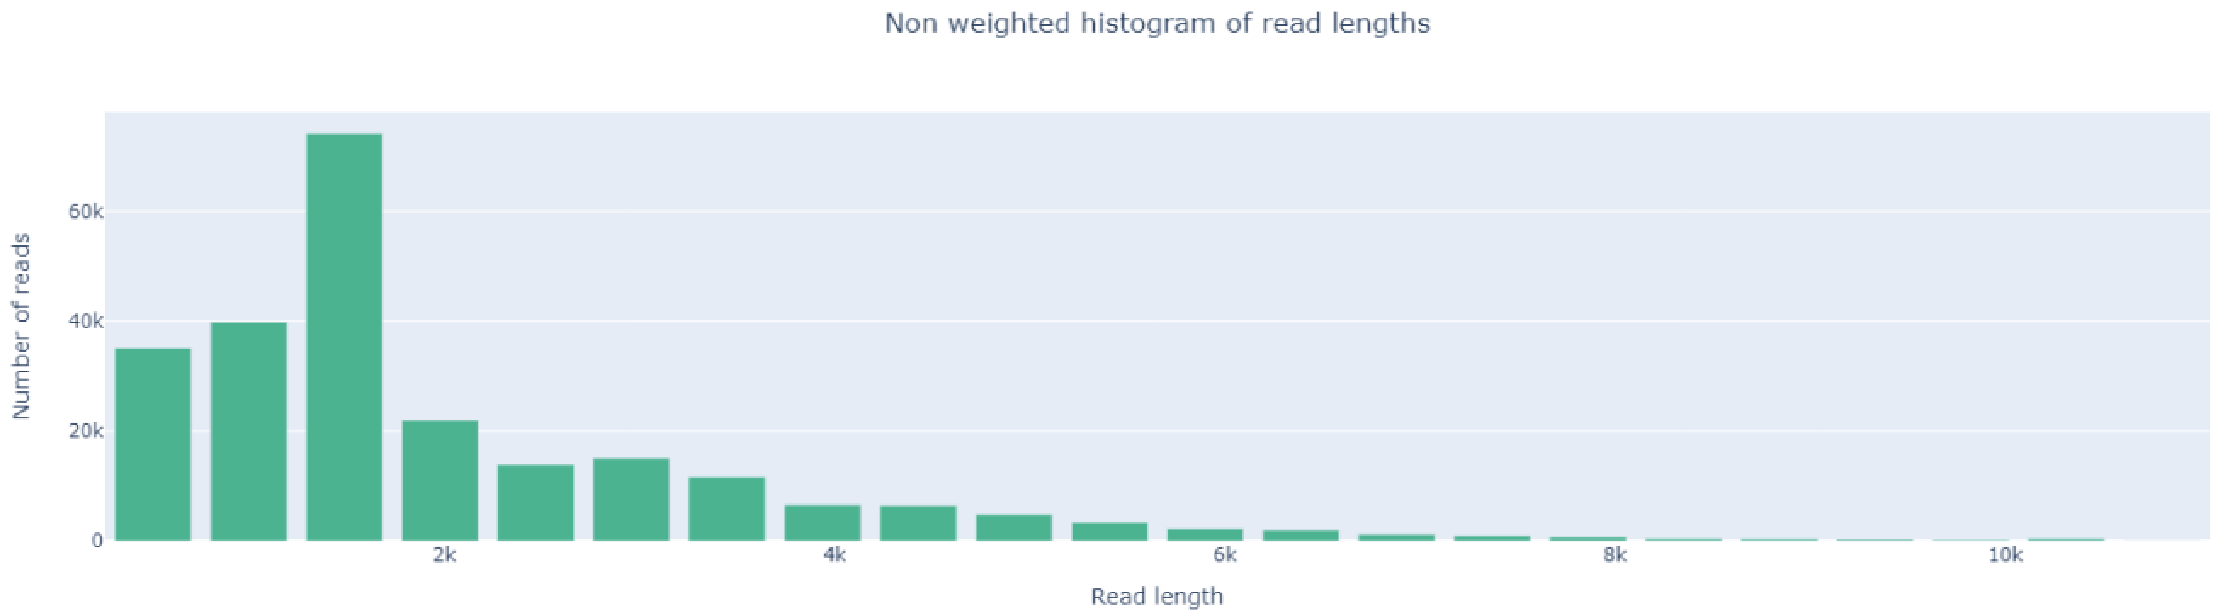 \
In de hierbij gecreëerd grafiek is te zien dat het merendeel van de reads onder 2kb zit. Maar ook dat er een kleine groep van reads net boven de 10kb zit. Dit zijn onze reads van DWV en met deze reads hebben wij de rest van ons onderzoek uitgevoerd. Dit zijn 258 reads. 

In het eerdere onderzoek was de gemiddelde q score van de reads 7.5 dit houdt in dat elke base maar een 
82.2% kans had om goed te zijn. Nu is er een gemiddelde q score van 10.9. Dit betekent dat elke base een 91.9% kans heeft om goed gebasecallt te zijn.

### Chopper 
<a href="https://github.com/wdecoster/chopper">Chopper</a>
is een combinatie van de tools: NanoFilt en NanoLyse. Deze tool filtert en trimt een fastq-bestand, op basis van gemiddelde read quality en minimale of maximale read length. Ook kan de tool een bepaald aantal baseparen van het begin of het einde van de reads verwijderen. Dit kan worden gedaan om adapter sequenties, Primer Artifacts of baseparen met slechte kwaliteit te verwijderen (wat vaker voorkomt aan het einde van een read) eruit te halen, en zo de kwaliteit van de data te verhogen.

DWV heeft ongeveer een lengte van 10kb - 11kb dus om deze eruit te halen hebben we alle reads boven de 10kb uit het grote bestand gefilterd om dit te doen hebben wij chopper (met de -l optie op 10000) gebruikt. Hiervoor is deze code gebruikt:

In [ ]:
gunzip -c /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz | chopper -l 10000 | gzip > /students/2023-2024/Thema07/Sick_beez/trimmed_fastq/filtered_reads.fastq.gz 

Wij hebben chopper alleen gebruikt voor het filteren op sequentie lengte omdat er bij het basecallen al op een minimum quality van 7 getrimmed is, er is dus niet met Chopper op kwaliteit gefilterd.

Hierna hebben wij <a href="https://github.com/wdecoster/NanoPlot">NanoPlot</a> op de getrimde data gerunt, zodat we alleen reads van minimaal 10kb (DWV reads) zien:

In [ ]:
NanoPlot --fastq "/students/2023-2024/Thema07/Sick_beez/trimmed_fastq/filtered_reads.fastq.gz" --outdir /students/2023-2024/Thema07/Sick_beez/trimmed_nanoplot/ --prefix "trimmed_" --only-report 

Na het selecteren op alleen DWV is de kwaliteit van de reads nog verder omhooggegaan. Voor de DWV reads was de gemiddelde q score 11.5. Dit betekent dat voor DWV de kans dat een base goed gebasecallt is 92.9% is

### FASTQ naar FASTA
Daarna hebben we in <a href="https://www.gnu.org/software/gawk/manual/gawk.html">Awk</a> de FASTQ file omgezet naar een FASTA file om deze te gebruiken met de volgende tool, <a href="http://www.clustal.org/omega/">Clustal Omega</a>.
AWK is een populaire text-processing programmeertaal op GNU/Linux. \
Het van FASTQ omzetten in FASTA lukte aanvankelijk niet in snakemake en dit hadden we dus met terminal code gedaan. Uiteindelijk hebben we het wel werkende gekregen in snakemake, dit hebben we gedaan met het volgende commando:

In [ ]:
gunzip -c /students/2023-2024/Thema07/Sick_beez/trimmed_fastq/filtered_reads.fastq.gz | awk '{if(NR%4==1) {printf(">%s\n",substr($0,2));} else if(NR%4==2) print;}' > /students/2023-2024/Thema07/Sick_beez/trimmed_fasta/filtered_reads.fasta 

## Clustal Omega
<a href="http://www.clustal.org/omega/">Clustal Omega</a> is een multiple sequence alignment (MSA) programma. Net als de voorganger <a href="http://www.clustal.org/clustal2/">ClustalW</a>, kan het DNA-, RNA- en eiwitsequenties allignen. ClustalW komt uit 1994, en Clustal Omega komt uit 2016. Clustal Omega maakt gebruik van met seeded guide trees en HMM profile-profile techniques, en werkt alleen bij 3 of meer sequenties. 

In [ ]:
clustalo -i /students/2023-2024/Thema07/Sick_beez/trimmed_fasta/fileter_reads.fasta -o /students/2023-2024/Thema07/Sick_beez/output_clustalo/output_omega.msa.fa

De eerste keer hadden thread count meegegeven, waardoor deze op de default van 1 thread runde. Na 30 uur was de server nogsteeds bezig. We hebben deze uitgezet en hebben de command line nog een keer gerunt maar dan met 40 threads in plaats van de default thread count.

In [ ]:
clustalo -i /students/2023-2024/Thema07/Sick_beez/trimmed_fasta/filtered_reads.fasta -o /students/2023-2024/Thema07/Sick_beez/output_clustalo/output_omega.msa.fa --threads 40


Hij deed hier nu maar 3-4 uur over, dit is een hele verbetering. We hadden echter geen guide tree optie meegegeven, waardoor we het opnieuw moesten runnen, met '--guidetree-out' erachter.

In [ ]:
clustalo -i /students/2023-2024/Thema07/Sick_beez/trimmed_fasta/filtered_reads.fasta -o /students/2023-2024/Thema07/Sick_beez/output_clustalo/output_omega.aln --threads 80 --guidetree-out /students/2023-2024/Thema07/Sick_beez/output_clustalo/output_tree.txt 

Hierboven is de code gerunt met de guide tree optie erbij, ook hebben wij gekozen voor 80 threads zodat de tool nog sneller klaar zou zijn. De laatste run (met guidetree) duurde 2 uur.

## Boom visualisatie 
<a href="http://www.clustal.org/omega/">Clustal Omega</a>'s phylogenetische boom is in een <a href="https://en.wikipedia.org/wiki/Newick_format">Newick tree format</a>. Om van de newick file naar een zichtbare phylogenetische boom te gaan is de tool <a href="https://pypi.org/project/ete3/">ete3</a> gebruikt. \
Environment for Tree Exploration (ETE) is een programming toolkit in Python dat kan helpen bij het opnieuw construeren, manipuleren, analyseren en visualiseren van fylogenetische bomen (clustering trees of andere tree-like data structure worden ook ondersteund).

<a href="https://pypi.org/project/ete3/">ete3</a> zet de <a href="http://marvin.cs.uidaho.edu/Teaching/CS515/newickFormat.html">newick file format</a> om in een visueel bestand. De output van deze tool is een <a href="https://nl.wikipedia.org/wiki/Fylogenetische_stamboom">phylogenetische boom</a>. 


In [ ]:
from ete3 import Tree 

tree_path = "/students/2023-2024/Thema07/Sick_beez/output_clustalo/output_tree.txt"
tree = Tree(tree_path)
tree.show() 

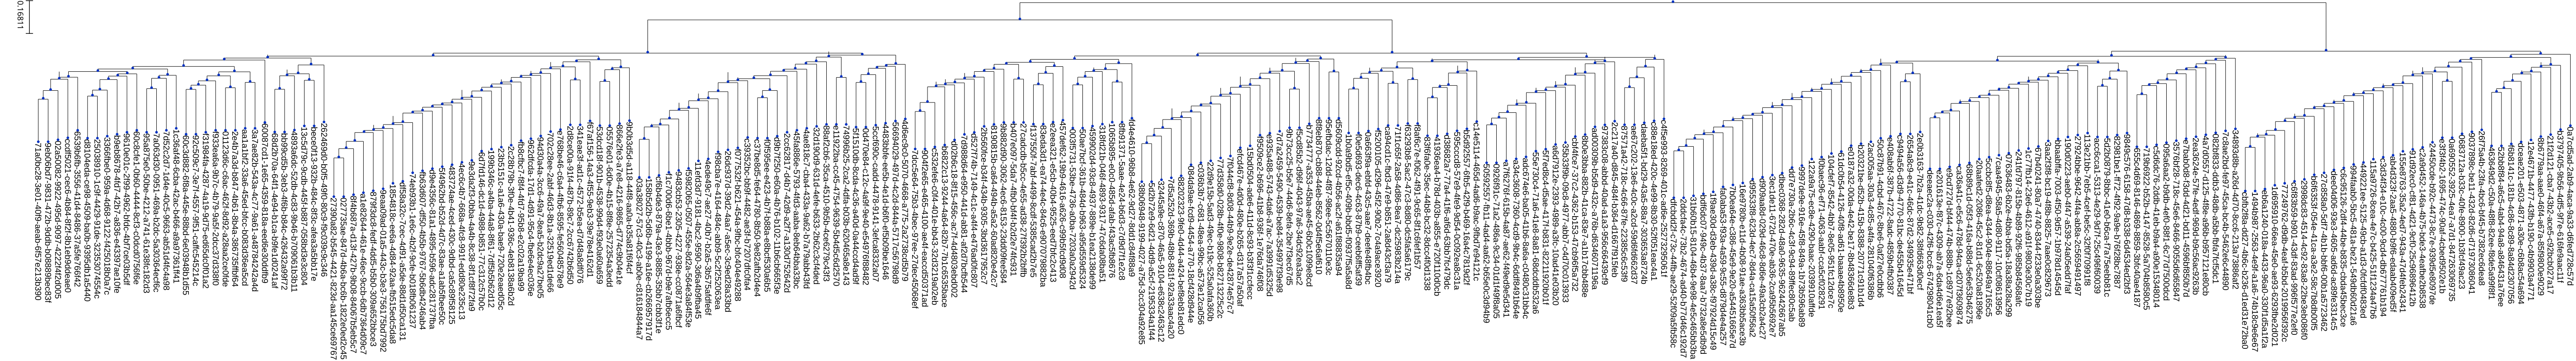 \
De boom die hier uit kwam was niet erg goed, dit komt ook omdat de boom te veel entiteiten heeft. Onze sequencing methode is 92.9% accuraat, 7.1% van onze data is dus inaccuraat, bij al een ~2% verschil wordt het in de phylogenetische boom al als een nieuwe entiteit gemarkeerd, waardoor er te veel (verschillende) entiteiten/varianten zijn. Ook zijn de namen van de virussen hierdoor lastig te lezen en niet goed te begrijpen.

We hebben uiteindelijk besloten deze phylogenetische boom wel te gebruiken, omdat het probleem een limitatie van onze sequencing is, en dus niet goed te verhelpen is.
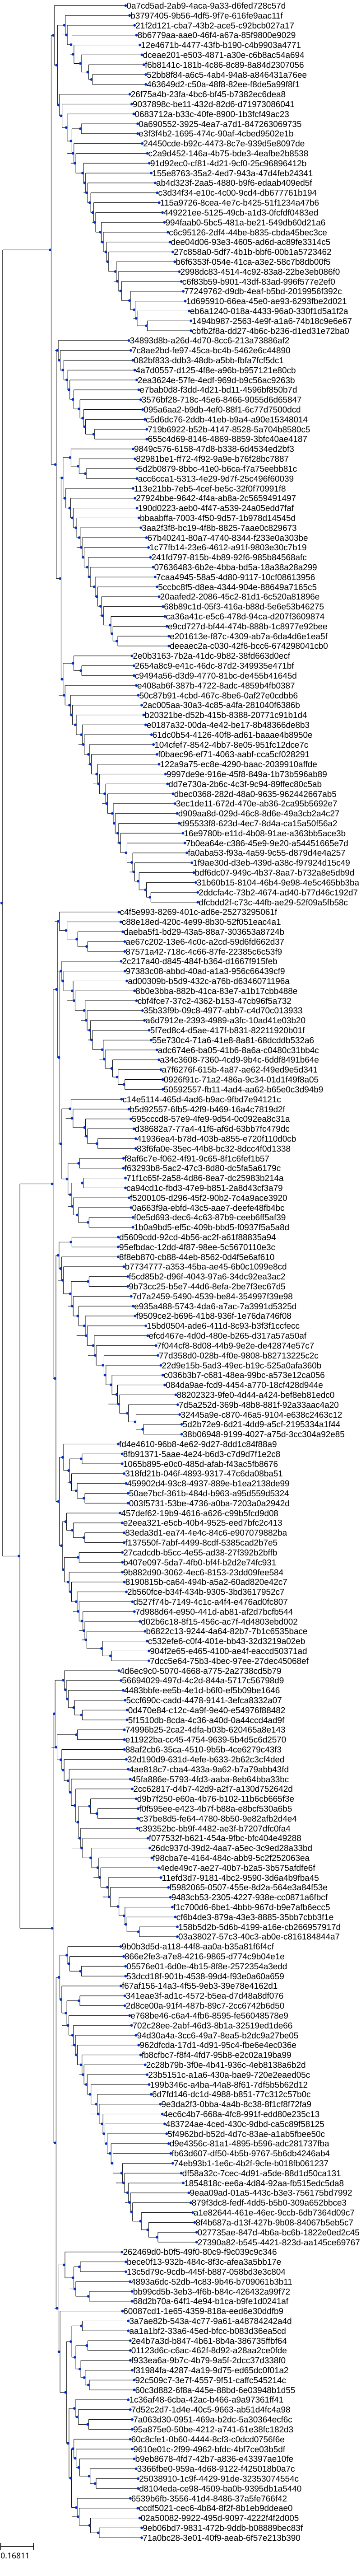

## Missmatch en mutatie hotspots
<a href="https://biopython-tutorial.readthedocs.io/en/latest/notebooks/06%20-%20Multiple%20Sequence%20Alignment%20objects.html">AlignIO</a> is een multiple sequence Alignment Input/Output interface, AlignIO is onderdeel van de <a href="https://github.com/biopython/biopython">BIO</a> package. Wij gebruiken het om een figuur van de output van <a href="http://www.clustal.org/omega/">Clustal Omega</a> te genereren.

Hieronder is code waarmee met AlignIO de missmatch en mutatiehotspots grafiek is gemaakt, deze laat het aantal missmatches en matches per positie zien. Hieruit kan je opmaken waar de mutaties zitten en hoe vaak deze voorkomen.

In [ ]:
from Bio import AlignIO 
import matplotlib.pyplot as plt

alignment = AlignIO.read("/students/2023-2024/Thema07/Sick_beez/output_clustalo/output_omega.msa.fa", "fasta") 
matches = [sum(1 for seq in alignment[:, i] if seq == alignment[0, i]) for i in range(alignment.get_alignment_length())] 
mismatches = [alignment.get_alignment_length() - m for m in matches ] 
plt.figure(figsize=(10, 5)) 
plt.plot(range(1, alignment.get_alignment_length() + 1), mismatches, color='red', label='Mismatches') 
plt.plot(range(1, alignment.get_alignment_length() + 1), matches, color='blue', label='Matches') 
plt.xlabel('Position in Alignment') 
plt.ylabel('Number of Matches/Mismatches') 
plt.title('Mutation Hotspots') 
plt.legend() 
plt.show() 

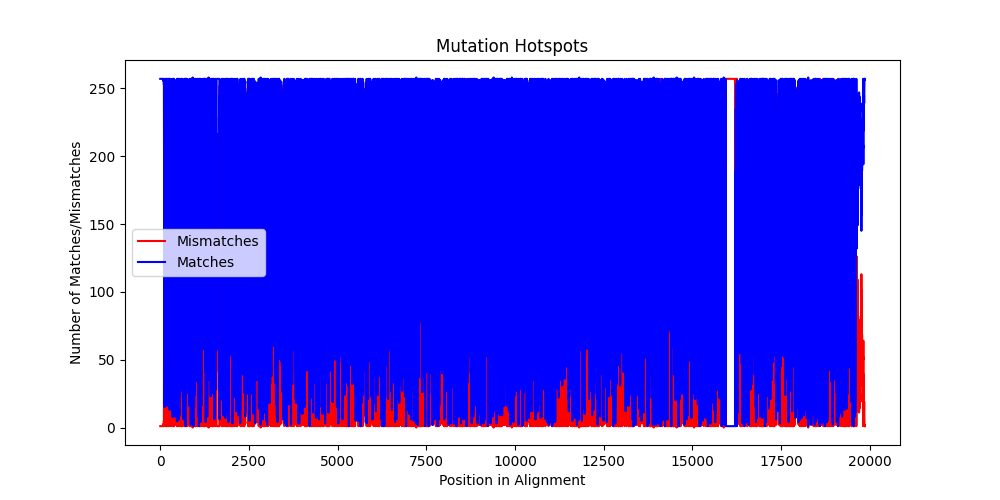 \
In deze grafiek is te zien dat de kwaliteit van de data niet heel hoog is. Omdat het verwacht is dat ongeveer 7% van de basen niet klopt is er door de hele multiple sequence allignment te zien dat er een hoop mismatches zijn. Maar er is ook duidelijk te zien dat er meerdere locaties in het genoom zijn waar het percentage mismatches veel hoger is dan 7%. Op sommige stukken gaat het percentage mismatches zelfs over de 20% heen. 

## Consensussequentie
Een consensussequentie (of canonieke sequentie) is de gecombineerde sequentie samengesteld uit de, per locatie meest frequente/voorkomende nucleotide (of aminozuur). Voor het maken van een consensussequentie zijn minimaal 3 sequenties nodig.

Hieronder staat een python script, die met behulp van <a href="https://biopython-tutorial.readthedocs.io/en/latest/notebooks/06%20-%20Multiple%20Sequence%20Alignment%20objects.html">AlignIO</a>, en <a href="https://docs.python.org/3/library/collections.html#collections.Counter">counter</a> werkt. Deze maakt van de MSA sequentie een consensus sequentie. De counter function returneerd wanneer deze een iterable (meestal een list) krijgt een dict, met als key alle unieke tekens (die in de iterable voorkomen), en als de daarbijbehorende value hoe vaak dit teken voorkwam (als een int).

In [ ]:
from Bio import AlignIO 
from collections import Counter 

# Load the alignment 
alignment = AlignIO.read("/students/2023-2024/Thema07/Sick_beez/output_clustalo/output_omega.msa.fa", "fasta") 

# Calculate the consensus sequence 
consensus_seq = "" 
for i in range(len(alignment[0])): 
    column = alignment[:, i] 
    counts = Counter(column) 
    consensus_base = counts.most_common(1)[0][0] 
    base_count = column.count(consensus_base) 
    base_percentage = base_count / len(column) 
    if base_percentage > 0.5 : 
        if consensus_base != '-': 
            consensus_seq += consensus_base 
        else: 
            consensus_seq += '-' 

# Write the consensus sequence to a file 
with open("/students/2023-2024/Thema07/Sick_beez/consensus/omega_consensus.fasta", "w") as output_file: 
    output_file.write(">Consensus\n") 
    output_file.write(consensus_seq + "\n") 

## Clustering
 <a href="https://github.com/torognes/vsearch">Vsearch</a> is een tool die sequenties die op elkaar lijken clustered. Alles wat op elkaar lijkt (90% overeenkomst) wordt door Vsearch geclustered en krijgt een consensus sequentie. Dit resulteert in 120 consensus sequentie.
Daarna hebben we met <a href="http://www.clustal.org/omega/">Clustal Omega</a> de op deze 120 consensus sequentie Multiple sequence allignment (MSA) gedaan.

In [ ]:
vsearch --cluster_fast '/students/2023-2024/Thema07/Sick_beez/trimmed_fastq/filtered_reads.fastq.gz' --id 0.85 --strand both --clusters '/students/2023-2024/Thema07/Sick_beez/output_vsearch/cluster_vsearch.fasta'. --threads 40 --consout "/students/2023-2024/Thema07/Sick_beez/output_vsearch/consensus_vsearch.fasta"  

clustalo -i /students/2023-2024/Thema07/Sick_beez/output_vsearch/consensus_vsearch.fasta -o /students/2023-2024/Thema07/Sick_beez/output_clustalo/vsearch_omega.aln --threads 80 --guidetree-out /students/2023-2024/Thema07/Sick_beez/output_clustalo/vsearch_tree.txt 

Deze python code kijkt per positie in de genomen welke base het meest voorkomt (in alle genomen). Als deze base meer dan 50% van de keren voorkomt wordt hij in de consensus sequentie geplaatst. Als er meer dan 50% van de keren een gap is wordt deze verwijdert. Als niks meer dan 50% heeft wordt er een gap in de consensus sequentie geplaatst. 

Hier kwam vergeleken met de vorige consensus sequentie, een drastische andere consensus sequentie uit.

Wegens tijd constricties zijn we hier niet verder op ingegaan.

## Primer3
<a href="https://github.com/primer3-org">Primer3</a>  is een veelgebruikt, open-source programma voor het designen van PCR-primers, hybridization probes en sequencing primers.

Het doel van ons onderzoek was het vinden van primers waarmee DWV goed geïdentificeerd kanworden. Wij hebben onze primers gevonden door primer3 over de consensus sequentie te runnen.

Wij hebben met een python script de eerste regel uit onze consensus sequentie gehaald, enters verwijdert, '-' met 'N' vervangen en van het RNA DNA gemaakt door de 'U' met 'T' te vervangen. Na alle data om te zetten in iets wat primer3 kan gebruiken hebben we primer3 gerunt. Primer3 retourneert de 5 beste primers.

In [ ]:
import primer3 

sequence = '' 
with open('/students/2023-2024/Thema07/Sick_beez/consensus/omega_consensus.fasta','r',encoding='UTF8') as consensus: 
    counter = 0 
    for line in consensus: 
        if counter != 0: 
            sequence += line 
        else: 
            counter += 1 

sequence = sequence.replace('\n','') 
sequence = sequence.replace('-','N') 
sequence = sequence.replace('U','T') 

primers = primer3.bindings.design_primers( 
seq_args={ 
    'SEQUENCE_ID': 'DWV', 
    'SEQUENCE_TEMPLATE': sequence, 
    }, 
global_args={ 
    'PRIMER_OPT_SIZE': 20, 
    'PRIMER_PICK_INTERNAL_OLIGO': 1, 
    'PRIMER_INTERNAL_MAX_SELF_END': 8, 
    'PRIMER_MIN_SIZE': 18, 
    'PRIMER_MAX_SIZE': 25, 
    'PRIMER_OPT_TM': 60.0, 
    'PRIMER_MIN_TM': 57.0, 
    'PRIMER_MAX_TM': 63.0, 
    'PRIMER_MIN_GC': 20.0, 
    'PRIMER_MAX_GC': 80.0, 
    'PRIMER_MAX_POLY_X': 100, 
    'PRIMER_INTERNAL_MAX_POLY_X': 100, 
    'PRIMER_SALT_MONOVALENT': 50.0, 
    'PRIMER_DNA_CONC': 50.0, 
    'PRIMER_MAX_NS_ACCEPTED': 0, 
    'PRIMER_MAX_SELF_ANY': 12, 
    'PRIMER_MAX_SELF_END': 8, 
    'PRIMER_PAIR_MAX_COMPL_ANY': 12, 
    'PRIMER_PAIR_MAX_COMPL_END': 8, 
    'PRIMER_PRODUCT_SIZE_RANGE': [ 
    [75,100],[100,125],[125,150], 
    [150,175],[175,200],[200,225] 
    ], 
    })

with open('/students/2023-2024/Thema07/Sick_beez/primer3_output/omega_primer3.txt', 'w', encoding='UTF8') as primer_file: 
    for key, value in primers.items(): 
        primer_file.write(f"{key}: {value}\n") 

Primer3 heeft 5 bijna identieke primers geretourneerd. Deze zijn lijken erg op elkaar met als enige verschil dat bij elke een deel van de primer een klein beetje verschoven is.

## Kraken 2 
<a href="https://github.com/DerrickWood/kraken2">Kraken 2</a> is een taxonomisch classificatiesysteem dat gebruik maakt van exact <a href="https://en.wikipedia.org/wiki/K-mer">k-mer</a> matches. Deze classificator matcht elke k-mer in een query sequence met de lowest common ancestor (LCA) van alle genomen die het gegeven k-mer bevatten. Ook kan je met kraken 2 een database/library maken, hier hebben wij het voor gebruikt.

In [ ]:
kraken2-build --add-to-library /students/2023-2024/Thema07/Sick_beez/genomes/bee.fna --db /students/2023-2024/Thema07/Sick_beez/kraken2_db/DWVdb --threads 50

Dit kraken 2 command returneerde een database, die we in het volgende command hebben toegepast op onze data.

In [ ]:
kraken2 --db /students/2023-2024/Thema07/Sick_beez/kraken2_db/DWVdb --threads 50 --output /students/2023-2024/Thema07/Sick_beez/kraken2_output/results.txt --report /students/2023-2024/Thema07/Sick_beez/kraken2_output/report.txt /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz

We kregen onze database niet binnen redelijke tijd werkende in Kraken 2. Na wat experimenteren in bowtie 2, en het daarin werkende krijgen, hebben we besloten om in plaats van kraken 2
bowtie 2 te gebruiken. Bowtie 2 werkt net iets anders als kraken 2, in plaats van 1 database aan de hand van alle referentie genomen maken, maakt bowtie 2 voor elk referentie genoom een index.

## Bowtie2
We hebben bowtie 2 niet geintegreerd in onze snakemake pipeline, dit hebben we gedaan omdat de namen van de output bestanden (van bowtie 2) niet in te stellen zijn. Waardoor snakemake de ouput van de rule niet herkend.

<a href="https://bowtie-bio.sourceforge.net/bowtie2/index.shtml">Bowtie 2</a> is een relatief snelle en geheugenefficiënte tool voor het vinden van reads in een reference/consensus genoom, een sequence alignment algorithms. Bowtie 2 is vooral goed in het uitlijnen op relatief lange genomen (bijvoorbeeld die van zoogdieren). Bowtie2-build indexeert het genoom met een zogeheten FM Index, wat het werkgeheugen gebruik relatief laag houdt. Het indexen van de genomen is nodig om deze met Bowtie 2 te kunnen gebruiken. Bowtie 2 ondersteunt gapped, local, and paired-end alignment modes.

Eerst hebben we met bowtie 2 indexen gemaakt van bijen RNA en verschillende RNA virussen, waaronder DWV. \
Deze virussen zijn:
- <a href="https://www.ncbi.nlm.nih.gov/datasets/taxonomy/198112/">Deformed wing virus</a>
- <a href="https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000851425.1/">Sacbrood virus</a>
- <a href="https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000847625.1/">Black queen virus</a>
- <a href="https://www.ncbi.nlm.nih.gov/datasets/taxonomy/1547219/">Lake sinai virus</a>
- <a href="https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000856345.1/">Bee paralysis virus</a>

De referentie genomen van de virussen die wij hebben gebruikt zijn allemaal afkomstig van NCBI en zijn te bezoeken door op de naam van de virussen te clicken.

In [ ]:
bowtie2-build /students/2023-2024/Thema07/Sick_beez/genomes/rnabee.fa /students/2023-2024/Thema07/Sick_beez/bowtie2_index/bee_index
bowtie2-build /students/2023-2024/Thema07/Sick_beez/genomes/DWV.fna /students/2023-2024/Thema07/Sick_beez/bowtie2_index/DWV_index
bowtie2-build /students/2023-2024/Thema07/Sick_beez/genomes/sacbrood_virus.fna /students/2023-2024/Thema07/Sick_beez/bowtie2_index/sacbrood_index
bowtie2-build /students/2023-2024/Thema07/Sick_beez/genomes/black_queen_virus.fna /students/2023-2024/Thema07/Sick_beez/bowtie2_index/blackqueen_index
bowtie2-build /students/2023-2024/Thema07/Sick_beez/genomes/lake_sinai_virus.fna /students/2023-2024/Thema07/Sick_beez/bowtie2_index/lakesinai_index
bowtie2-build /students/2023-2024/Thema07/Sick_beez/genomes/bee_paralysis_virus.fna /students/2023-2024/Thema07/Sick_beez/bowtie2_index/paralysis_index

Met behulp van onze bijen RNA index, hebben we gekeken of er RNA van bijen in onze data/reads zit.

In [ ]:
bowtie2 -x /students/2023-2024/Thema07/Sick_beez/bowtie2_index/bee_index -U /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz -S /students/2023-2024/Thema07/Sick_beez/bowtie2_output/bee.sam

Omdat <a href="https://bowtie-bio.sourceforge.net/bowtie2/index.shtml">Bowtie 2</a> met de standaard instellingen geen match kon vinden, hebben we doormiddel van de bowtie 2 instellingen de vereisten wat verlaagt. -N staat voor de hoeveelheid mismatches die zijn toegestaan, -L staat voor de minimale <a href="https://en.wikipedia.org/wiki/Spaced_seed">seed</a> length en -i beïnvloedt de gevoeligheid en specificiteit, zo staat S voor sensitive (de instelling die wij gebruiken), 1 staat voor hoeveel base er per keer aan de seed worden toegevoegd en 0.90 de minimale score nodig om met een seed door te mogen gaan.

In [ ]:
bowtie2 -N 1 -L 18 -i S,1,0.90 -x /students/2023-2024/Thema07/Sick_beez/bowtie2_index/bee_index -U /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz -S /students/2023-2024/Thema07/Sick_beez/bowtie2_output/bee.sam

Met de soepelere eisen hebben we met behulp van onze indexen gekeken of DWV en potentieel andere soorten virussen in onze data/reads voorkomen.

In [ ]:
bowtie2 -N 1 -L 18 -i S,1,0.90 -x /students/2023-2024/Thema07/Sick_beez/bowtie2_index/DWV_index -U /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz -S /students/2023-2024/Thema07/Sick_beez/bowtie2_output/DWV.sam
bowtie2 -N 1 -L 18 -i S,1,0.90 -x /students/2023-2024/Thema07/Sick_beez/bowtie2_index/sacbrood_index -U /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz -S /students/2023-2024/Thema07/Sick_beez/bowtie2_output/sacbrood.sam
bowtie2 -N 1 -L 18 -i S,1,0.90 -x /students/2023-2024/Thema07/Sick_beez/bowtie2_index/blackqueen_index -U /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz -S /students/2023-2024/Thema07/Sick_beez/bowtie2_output/blackqueen.sam
bowtie2 -N 1 -L 18 -i S,1,0.90 -x /students/2023-2024/Thema07/Sick_beez/bowtie2_index/lakesinai_index -U /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz -S /students/2023-2024/Thema07/Sick_beez/bowtie2_output/lakesinai.sam
bowtie2 -N 1 -L 18 -i S,1,0.90 -x /students/2023-2024/Thema07/Sick_beez/bowtie2_index/paralysis_index -U /students/2023-2024/Thema07/Sick_beez/big_guppy/big_guppy.fastq.gz -S /students/2023-2024/Thema07/Sick_beez/bowtie2_output/paralysis.sam

Er kwamen van al onze reads 0 overeen met een van de referentie genomen, ook die van DWV. Wat betekent dat het referentiegenoom voor DWV van NCBI niet nauw genoeg overeenkomt met onze DWV reads.